# References

The code from the following articles have been adopted for this study.

********************************************************************************
###  Tensorflow reference
*    Title: Text classification with an RNN
*    Author: Google, Tensorflow
*    Date: 2021
*    Availability: https://www.tensorflow.org/tutorials/text/text_classification_rnn 
********************************************************************************
### Transfer learning reference
*    Title: Transfer learning and fine-tuning
*    Author: Google, Tensorflow
*    Date: 2021
*    Availability: https://www.tensorflow.org/tutorials/images/transfer_learning
********************************************************************************
### Preprocessing, LSTM and embedding reference
*    Title: Classify Toxic Online Comments with LSTM and GloVe
*    Author: Susan Li
*    Date: 2019
*    Availability: https://github.com/susanli2016/NLP-with-Python/blob/master/Toxic%20Comments%20LSTM%20GloVe.ipynb
********************************************************************************
###  GloVe model reference
*    Title: Word vectorization using GloVe
*    Author: Japneet Singh Chawla
*    Date: 2018
*    Availability: https://medium.com/analytics-vidhya/word-vectorization-using-glove-76919685ee0b
********************************************************************************
###  Mittens reference
*    Title: Fine tune GloVe embeddings using Mittens
*    Author: Sivasurya Santhanam
*    Date: 2020
*    Availability: https://towardsdatascience.com/fine-tune-glove-embeddings-using-mittens-89b5f3fe4c39
********************************************************************************
###  EMBER dataset reference
*    Title: EMBER: An Open Dataset for Training Static PE Malware Machine Learning Models
*    Author: Hyrum S. Anderson, Phil Roth
*    Date: 2018
*    Availability: https://github.com/elastic/ember
********************************************************************************
###  Mal-API-2019 dataset reference
*    Title: Deep learning based Sequential model for malware analysis using Windows exe API Calls
*    Author: Ahmet Faruk Yazı, Ferhat Ozgur Catak, Ensar Gul
*    Date: 2020
*    Availability: https://github.com/ocatak/malware_api_class
********************************************************************************

# Start

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle

In [ ]:
# Define plot
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
# Define f1 score
import keras.backend as K

def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [ ]:
from tensorflow.keras import regularizers, initializers, optimizers, callbacks
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocess text

In [ ]:
# Load target dataset & tokenize
df = pd.read_csv('/datasets/target_final.txt', names=['calls', 'types', 'Backdoor', 'Trojan', 'Spyware', 'Worms', 'Dropper', 'Downloader', 'Virus', 'Adware'])

In [ ]:
calls_list = []
for i in range(len(df)):
  calls_list.append(df.calls[i])

In [ ]:
labels = ['Backdoor', 'Trojan', 'Spyware', 'Worms', 'Dropper', 'Downloader', 'Virus', 'Adware']
y = df[labels].values

In [ ]:
print('Sample data:', y[1])

Sample data: [0 0 0 1 0 0 0 0]


In [ ]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(calls_list)
sequences = tokenizer.texts_to_sequences(calls_list)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))

Vocabulary size: 280


In [ ]:
data = pad_sequences(sequences, padding = 'post', maxlen = 1000)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', y.shape)

Shape of data tensor: (7107, 1000)
Shape of label tensor: (7107, 8)


In [ ]:
type(y)

numpy.ndarray

In [ ]:
indices = np.arange(data.shape[0])
np.random.seed(0)
np.random.shuffle(indices)
data = data[indices]
labels = y[indices]

In [ ]:
num_validation_samples = int(0.2*data.shape[0])
x_train = data[: -num_validation_samples]
y_train = labels[: -num_validation_samples]
x_val = data[-num_validation_samples: ]
y_val = labels[-num_validation_samples: ]
print('Number of entries in each category:')
print('training: ', y_train.sum(axis=0))
print('validation: ', y_val.sum(axis=0))

Number of entries in each category:
training:  [784 815 673 786 702 805 810 311]
validation:  [217 186 159 215 189 196 191  68]


In [ ]:
print('Tokenized sentences: \n', data[10])
print('One hot label: \n', labels[10])

Tokenized sentences: 
 [ 2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10 10  3  2
  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10
 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3
  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7
  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10
 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3
  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6
 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10
  3  2  7  6 10 10  3  2  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2
  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10
 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3
  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7
  6 10 10  3  2  6 10 10  3  2  7  6 10 10  3  2  6 10 10  3  2  7  6 10
 10  3  2  6 10 10  3  2  7 

# Model training

## 1. 256 BiLSTM Target

In [ ]:
# Load GloVe word embedding
embeddings_index = {}
embedding_path = "/embeddings/target_glove.txt"
f = open(embedding_path)
print('Loading GloVe from:', embedding_path, '...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")
np.random.seed(10)
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/embeddings/target_glove.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
# Configure the model
sequence_input = Input(shape=(1000,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = 1000,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256, return_sequences=True,name='lstm_layer'))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(8, activation="softmax")(x)

In [ ]:
# Compile the model
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', f1_metric])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embeddings (Embedding)       (None, 1000, 100)         28100     
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

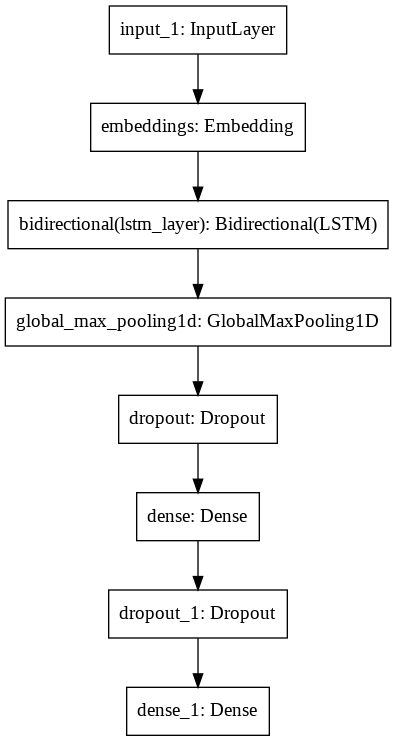

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
# Add callback & early stopping
overfitCallback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
         ModelCheckpoint(filepath='/models/256_bilstm/best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
# Train the model
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 50, batch_size=64, validation_data=(x_val, y_val), callbacks=[overfitCallback])

Training progress:
Epoch 1/50
89/89 [==============================] - 53s 206ms/step - loss: 0.4353 - accuracy: 0.1542 - val_loss: 0.3511 - val_accuracy: 0.2519
Epoch 2/50
89/89 [==============================] - 17s 189ms/step - loss: 0.3625 - accuracy: 0.2567 - val_loss: 0.3289 - val_accuracy: 0.3265
Epoch 3/50
89/89 [==============================] - 17s 193ms/step - loss: 0.3419 - accuracy: 0.3242 - val_loss: 0.3145 - val_accuracy: 0.3835
Epoch 4/50
89/89 [==============================] - 17s 197ms/step - loss: 0.3239 - accuracy: 0.3726 - val_loss: 0.3010 - val_accuracy: 0.4236
Epoch 5/50
89/89 [==============================] - 18s 198ms/step - loss: 0.3130 - accuracy: 0.4012 - val_loss: 0.2904 - val_accuracy: 0.4490
Epoch 6/50
89/89 [==============================] - 17s 194ms/step - loss: 0.3003 - accuracy: 0.4335 - val_loss: 0.2884 - val_accuracy: 0.4680
Epoch 7/50
89/89 [==============================] - 17s 193ms/step - loss: 0.3000 - accuracy: 0.4205 - val_loss: 0.2789 - v

In [ ]:
# Load the best weights
model.load_weights('/models/256_bilstm/best_model.h5')

In [ ]:
# Evaluate the model: Accuracy - F1 score
model.evaluate(x_val, y_val, batch_size=64)

23/23 [==============================] - 32s 79ms/step - loss: 0.2239 - accuracy: 0.6130 - f1_metric: 0.5883


[0.22393031418323517, 0.6150597929954529, 0.6049245595932007]

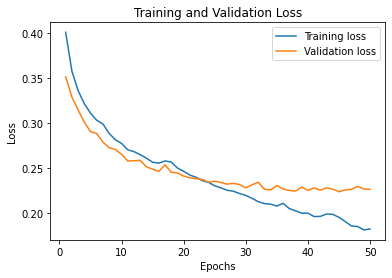

In [ ]:
# Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show();
plt.savefig('/models/256_bilstm/256_bilstm_loss.png')

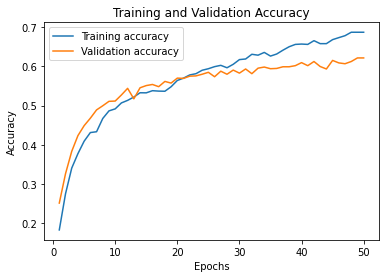

In [ ]:
# Plot accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.show();
plt.savefig('/models/256_bilstm/256_bilstm_accuracy.png')

In [ ]:
# Save history
with open('/models/256_bilstm/256_bilstm_trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#history = pickle.load(open('/models/256_bilstm/256_bilstm_trainHistoryDict'), "rb")

## 1.1. 256 LSTM Target

In [ ]:
# Load GloVe word embedding
embeddings_index = {}
embedding_path = "/embeddings/target_glove.txt"
f = open(embedding_path)
print('Loading GloVe from:', embedding_path, '...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")
np.random.seed(10)
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/embeddings/target_glove.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
# Configure the model
sequence_input = Input(shape=(1000,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = 1000,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = LSTM(256, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(8, activation="softmax")(x)

In [ ]:
# Compile the model
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', f1_metric])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embeddings (Embedding)       (None, 1000, 100)         28100     
_________________________________________________________________
lstm_layer (LSTM)            (None, 1000, 256)         365568    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [ ]:
# Add callback & early stopping
overfitCallback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
         ModelCheckpoint(filepath='/models/256_lstm/best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
# Train the model
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 50, batch_size=64, validation_data=(x_val, y_val), callbacks=[overfitCallback])

Training progress:
Epoch 1/50
89/89 [==============================] - 41s 98ms/step - loss: 0.4514 - accuracy: 0.1388 - val_loss: 0.3579 - val_accuracy: 0.2519
Epoch 2/50
89/89 [==============================] - 8s 91ms/step - loss: 0.3728 - accuracy: 0.2350 - val_loss: 0.3383 - val_accuracy: 0.3118
Epoch 3/50
89/89 [==============================] - 8s 92ms/step - loss: 0.3500 - accuracy: 0.2941 - val_loss: 0.3230 - val_accuracy: 0.3631
Epoch 4/50
89/89 [==============================] - 8s 94ms/step - loss: 0.3345 - accuracy: 0.3366 - val_loss: 0.3118 - val_accuracy: 0.4068
Epoch 5/50
89/89 [==============================] - 8s 94ms/step - loss: 0.3237 - accuracy: 0.3692 - val_loss: 0.2990 - val_accuracy: 0.4307
Epoch 6/50
89/89 [==============================] - 8s 96ms/step - loss: 0.3184 - accuracy: 0.3897 - val_loss: 0.3057 - val_accuracy: 0.4328
Epoch 7/50
89/89 [==============================] - 9s 96ms/step - loss: 0.3140 - accuracy: 0.3985 - val_loss: 0.2923 - val_accuracy: 

In [ ]:
# Load the best weights
model.load_weights('/models/256_lstm/best_model.h5')

In [ ]:
# Evaluate the model: Accuracy - F1 score
model.evaluate(x_val, y_val, batch_size=64)

23/23 [==============================] - 31s 43ms/step - loss: 0.2281 - accuracy: 0.5828 - f1_metric: 0.5635


[0.22628629207611084, 0.5960590839385986, 0.5823948383331299]

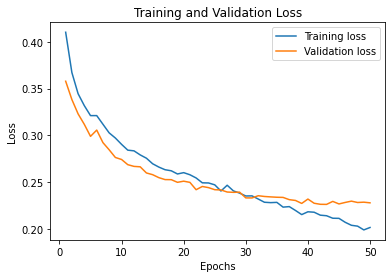

In [ ]:
# Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show();
plt.savefig('/models/256_lstm/256_lstm_loss.png')

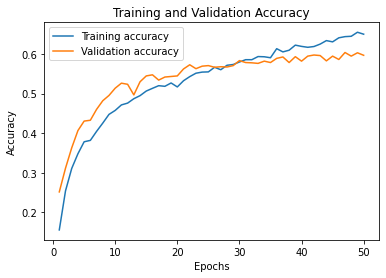

In [ ]:
# Plot accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.show();
plt.savefig('/models/256_lstm/256_lstm_accuracy.png')

In [ ]:
# Save history
with open('/models/256_lstm/256_lstm_trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
#history = pickle.load(open('/models/256_lstm/256_lstm_trainHistoryDict'), "rb")

## 2. 256 BiLSTM TF

In [ ]:
# Load GloVe word embedding
embeddings_index = {}
embedding_path = "/embeddings/source_glove.txt"
f = open(embedding_path)
print('Loading GloVe from:', embedding_path, '...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")
np.random.seed(10)
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/embeddings/source_glove.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
# Configure the model
sequence_input = Input(shape=(1000,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = 1000,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256, return_sequences=True,name='lstm_layer'))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(8, activation="softmax")(x)

In [ ]:
# Compile the model
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', f1_metric])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embeddings (Embedding)       (None, 1000, 100)         28100     
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [ ]:
# Add callback & early stopping
overfitCallback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
         ModelCheckpoint(filepath='/models/tf/best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
# Train the model
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 50, batch_size=64, validation_data=(x_val, y_val), callbacks=[overfitCallback])

Training progress:
Epoch 1/50
89/89 [==============================] - 53s 209ms/step - loss: 0.4369 - accuracy: 0.1438 - val_loss: 0.3558 - val_accuracy: 0.2723
Epoch 2/50
89/89 [==============================] - 17s 191ms/step - loss: 0.3712 - accuracy: 0.2262 - val_loss: 0.3395 - val_accuracy: 0.3322
Epoch 3/50
89/89 [==============================] - 17s 195ms/step - loss: 0.3506 - accuracy: 0.2943 - val_loss: 0.3260 - val_accuracy: 0.3251
Epoch 4/50
89/89 [==============================] - 18s 199ms/step - loss: 0.3353 - accuracy: 0.3239 - val_loss: 0.3152 - val_accuracy: 0.3575
Epoch 5/50
89/89 [==============================] - 17s 196ms/step - loss: 0.3306 - accuracy: 0.3374 - val_loss: 0.3122 - val_accuracy: 0.4011
Epoch 6/50
89/89 [==============================] - 17s 195ms/step - loss: 0.3230 - accuracy: 0.3627 - val_loss: 0.3045 - val_accuracy: 0.3983
Epoch 7/50
89/89 [==============================] - 17s 194ms/step - loss: 0.3128 - accuracy: 0.3849 - val_loss: 0.3012 - v

In [ ]:
# Load the best weights
model.load_weights('/models/tf/best_model.h5')

In [ ]:
# Evaluate the model: Accuracy - F1 score
model.evaluate(x_val, y_val, batch_size=64)

23/23 [==============================] - 2s 72ms/step - loss: 0.2315 - accuracy: 0.5869 - f1_metric: 0.5729


[0.23145951330661774, 0.586910605430603, 0.5728511810302734]

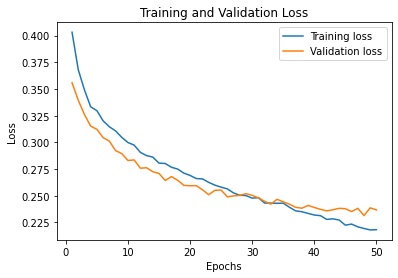

In [ ]:
# Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show();
plt.savefig('/models/tf/tf_loss.png')

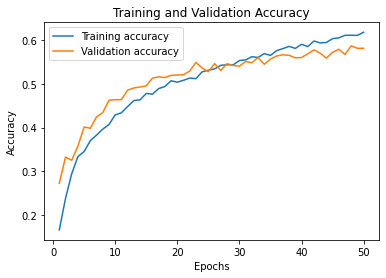

In [ ]:
# Plot accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.show();
plt.savefig('/models/tf/tf_accuracy.png')

In [ ]:
# Save history
with open('/models/tf/tf_trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## 3. 256 BiLSTM TF - Fine-tuned

In [ ]:
# Load GloVe word embedding
embeddings_index = {}
embedding_path = "/embeddings/tf_finetuned_glove.txt"
f = open(embedding_path)
print('Loading GloVe from:', embedding_path, '...', end='')
for line in f:
    values = line.split()
    word = values[0]
    embeddings_index[word] = np.asarray(values[1:], dtype='float32')
f.close()
print("Done.\n Proceeding with Embedding Matrix...", end="")
np.random.seed(10)
embedding_matrix = np.random.random((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
print(" Completed!")

Loading GloVe from: /content/drive/MyDrive/embeddings/tf_finetuned_glove.txt ...Done.
 Proceeding with Embedding Matrix... Completed!


In [ ]:
# Configure the model
sequence_input = Input(shape=(1000,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = 1000,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256, return_sequences=True,name='lstm_layer'))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(8, activation="softmax")(x)

In [ ]:
# Compile the model
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy', f1_metric])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
embeddings (Embedding)       (None, 1000, 100)         28100     
_________________________________________________________________
bidirectional (Bidirectional (None, 1000, 512)         731136    
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0     

In [ ]:
# Add callback & early stopping
overfitCallback = [EarlyStopping(monitor='val_loss', min_delta=0, patience=10),
         ModelCheckpoint(filepath='/models/tf_finetune/best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
# Train the model
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 50, batch_size=64, validation_data=(x_val, y_val), callbacks=[overfitCallback])

Training progress:
Epoch 1/50
89/89 [==============================] - 86s 585ms/step - loss: 0.4427 - accuracy: 0.1545 - val_loss: 0.3486 - val_accuracy: 0.2738
Epoch 2/50
89/89 [==============================] - 50s 563ms/step - loss: 0.3617 - accuracy: 0.2554 - val_loss: 0.3316 - val_accuracy: 0.2942
Epoch 3/50
89/89 [==============================] - 50s 559ms/step - loss: 0.3440 - accuracy: 0.3131 - val_loss: 0.3120 - val_accuracy: 0.3899
Epoch 4/50
89/89 [==============================] - 50s 559ms/step - loss: 0.3318 - accuracy: 0.3422 - val_loss: 0.3030 - val_accuracy: 0.4286
Epoch 5/50
89/89 [==============================] - 50s 562ms/step - loss: 0.3206 - accuracy: 0.3751 - val_loss: 0.2973 - val_accuracy: 0.4483
Epoch 6/50
89/89 [==============================] - 50s 559ms/step - loss: 0.3083 - accuracy: 0.4141 - val_loss: 0.2882 - val_accuracy: 0.4645
Epoch 7/50
89/89 [==============================] - 50s 560ms/step - loss: 0.3016 - accuracy: 0.4193 - val_loss: 0.2838 - v

In [ ]:
# Load the best weights
model.load_weights('/models/tf_finetune/best_model.h5')

In [ ]:
# Evaluate the model: Accuracy - F1 score
model.evaluate(x_val, y_val, batch_size=64)

23/23 [==============================] - 34s 70ms/step - loss: 0.2236 - accuracy: 0.5890 - f1_metric: 0.5851


[0.2215270847082138, 0.6066150665283203, 0.6012930870056152]

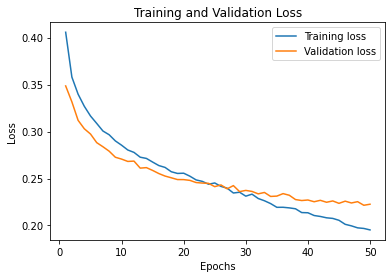

In [ ]:
# Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show();
plt.savefig('/models/tf_finetune/tf_finetune_loss.png')

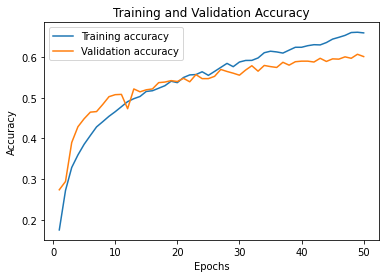

In [ ]:
# Plot accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.show();
plt.savefig('/models/tf_finetune/tf_finetune_accuracy.png')

In [ ]:
# Save history
with open('/models/tf_finetune/tf_finetune_trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

## Epoch Experiment

In [ ]:
# Configure the model
sequence_input = Input(shape=(1000,), dtype='int32')
embedding_layer = Embedding(len(word_index) + 1,
                           100,
                           weights = [embedding_matrix],
                           input_length = 1000,
                           trainable=False,
                           name = 'embeddings')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(LSTM(256, return_sequences=True,name='lstm_layer'))(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.5)(x)
preds = Dense(8, activation="softmax")(x)

In [ ]:
# Compile the model
model = Model(sequence_input, preds)
model.compile(loss = 'binary_crossentropy',
             optimizer='adam',
             metrics = ['accuracy'])

In [ ]:
# Train the model
print('Training progress:')
history = model.fit(x_train, y_train, epochs = 200, batch_size=64, validation_data=(x_val, y_val))

Training progress:
Epoch 1/200
89/89 [==============================] - 51s 199ms/step - loss: 0.4266 - accuracy: 0.1637 - val_loss: 0.3382 - val_accuracy: 0.3462
Epoch 2/200
89/89 [==============================] - 16s 179ms/step - loss: 0.3620 - accuracy: 0.2670 - val_loss: 0.3212 - val_accuracy: 0.3990
Epoch 3/200
89/89 [==============================] - 16s 179ms/step - loss: 0.3433 - accuracy: 0.3269 - val_loss: 0.3109 - val_accuracy: 0.4229
Epoch 4/200
89/89 [==============================] - 16s 179ms/step - loss: 0.3293 - accuracy: 0.3618 - val_loss: 0.2987 - val_accuracy: 0.4426
Epoch 5/200
89/89 [==============================] - 16s 181ms/step - loss: 0.3118 - accuracy: 0.4118 - val_loss: 0.2903 - val_accuracy: 0.4743
Epoch 6/200
89/89 [==============================] - 16s 181ms/step - loss: 0.3018 - accuracy: 0.4331 - val_loss: 0.2854 - val_accuracy: 0.4933
Epoch 7/200
89/89 [==============================] - 16s 182ms/step - loss: 0.2931 - accuracy: 0.4523 - val_loss: 0.2

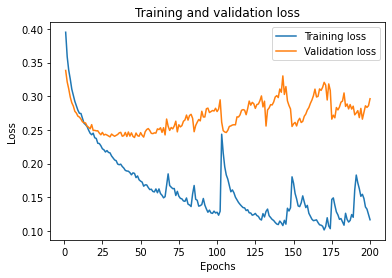

In [ ]:
# Plot loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.show();
plt.savefig('/models/200epoch/target_loss_200epoch.png')

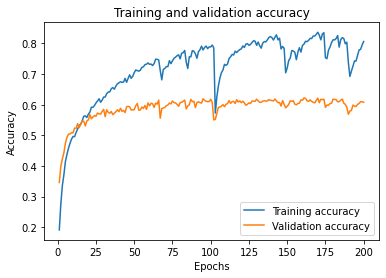

In [ ]:
# Plot accuracy
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()
#plt.show();
plt.savefig('/models/200epoch/target_accuracy_200epoch.png')

# Start of data processing

In [ ]:
# Import libraries
from glove import Corpus, Glove
from mittens import Mittens
import csv

## Source data preparation

In [ ]:
# Load the dataset
df = pd.read_csv('/datasets/source_final.txt', names=['calls'])

In [ ]:
df.head(3)

,calls
0,GetCurrentProcessId GetCurrentThreadId CloseHa...
1,GetModuleHandleExW GetModuleFileNameW GetStdHa...
2,HeapSize Sleep IsDebuggerPresent SetUnhandledE...


In [ ]:
# Get words
new_lines = [line.split() for line in df.calls]

## Target data preparation

In [ ]:
# Load datasets
train = pd.read_csv('/datasets/api-call-dataset/target_train_numerized.txt', names=['calls', 'types'])
test = pd.read_csv('/datasets/api-call-dataset/target_test_numerized.txt', names=['calls', 'types'])

In [ ]:
# Combine datasets
df = train.append(test, ignore_index=True)

In [ ]:
# Delete older datasets to free memory
del train
del test

In [ ]:
len(df)

7107

In [ ]:
# Get words
new_lines = [line.split() for line in df.calls]

## GloVe for source

In [ ]:
# Create new corpus
corpus = Corpus() 

In [ ]:
corpus.fit(new_lines, window=10)

In [ ]:
# Create GloVe model
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
# Train the GloVe model
glove.fit(corpus.matrix, epochs=100, no_threads=4, verbose=True)

Performing 100 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [ ]:
# Add corpus dictionary to GloVe model
glove.add_dictionary(corpus.dictionary)

In [ ]:
glove.word_vectors[glove.dictionary['GetCurrentProcessId']]

array([-0.01698215, -0.34070298, -0.39242672, -0.42930272, -0.31761357,
       -0.11675294,  0.49647759,  0.0321332 , -0.49227692, -0.62632739,
       -0.14105358, -0.28816024, -0.04764402,  0.18963497,  0.17112266,
        0.93523317,  0.35682526, -0.2187729 , -0.49530892, -0.39461219,
       -0.03247362,  0.12712684,  0.48562928,  0.1322491 , -0.50227825,
        0.1181357 , -0.54009309,  0.56100411,  0.57321039, -0.37443443,
        0.31162458,  0.47935116, -0.01205809, -0.19767736,  0.04069966,
        0.26780782, -0.30360378,  0.41161091, -0.26081614,  0.08046009,
       -0.0803839 , -0.40695873,  0.2556161 , -0.14086917, -0.29877871,
        0.34236567,  0.46133518, -0.14668461,  0.70869146,  0.28274896,
        0.07523749, -0.04193935,  0.1965594 ,  0.02072556,  0.22956182,
       -0.03705685,  0.5032507 ,  0.25329853, -0.43092908, -0.34674474,
        0.90017799,  0.53468325, -0.34508802, -0.2261083 ,  0.20753389,
       -0.0908647 , -0.24108487,  0.2267768 ,  0.34512342,  0.00

In [ ]:
# Save the GloVe model
with open("/embeddings/source_glove.txt", "w") as f:
    for word in glove.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 100):
            f.write(str(glove.word_vectors[glove.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")

## GloVe for target

In [ ]:
# Create new corpus
corpus = Corpus() 

In [ ]:
corpus.fit(new_lines, window=10)

In [ ]:
# Create GloVe model
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
# Train the GloVe model
glove.fit(corpus.matrix, epochs=100, no_threads=4, verbose=True)

Performing 100 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99


In [ ]:
# Add corpus dictionary to GloVe model
glove.add_dictionary(corpus.dictionary)

In [ ]:
# Save the GloVe model
with open("/embeddings/target_glove.txt", "w") as f:
    for word in glove.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 100):
            f.write(str(glove.word_vectors[glove.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")

## GloVe Fine Tune

In [ ]:
# Load datasets
train = pd.read_csv('/datasets/api-call-dataset/target_train_numerized.txt', names=['calls', 'types'])
test = pd.read_csv('/datasets/api-call-dataset/target_test_numerized.txt', names=['calls', 'types'])

In [ ]:
# Combine datasets
df = train.append(test, ignore_index=True)

In [ ]:
# Delete older datasets to free memory
del train
del test

In [ ]:
# Get words
new_lines = [line.split() for line in df.calls]

In [ ]:
# Create new corpus
corpus = Corpus()

In [ ]:
corpus.fit(new_lines, window=10)

In [ ]:
# Load GloVe model
def glove2dict(glove_filename):
    with open(glove_filename, encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=' ',quoting=csv.QUOTE_NONE)
        embed = {line[0]: np.array(list(map(float, line[1:-1])))
                for line in reader}
    return embed
glove_path = "/embeddings/source_glove.txt"
pre_glove = glove2dict(glove_path)

In [ ]:
corpus.matrix.A

array([[    0.        ,  7482.2121582 ,  3282.49105835, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        , 30323.01660156, ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       ...,
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ],
       [    0.        ,     0.        ,     0.        , ...,
            0.        ,     0.        ,     0.        ]])

In [ ]:
len(corpus.dictionary)

277

In [ ]:
# Create & train mittens model
mittens_model = Mittens(n=100, max_iter=100)
new_embeddings = mittens_model.fit(
    corpus.matrix.A,
    vocab=corpus.dictionary,
    initial_embedding_dict= pre_glove)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Iteration 100: loss: 1421.376953125

In [ ]:
new_embeddings

array([[-0.294923  ,  0.02506275,  0.16276915, ..., -0.09253753,
         0.56687343,  0.4047298 ],
       [-0.69499695, -0.37334073,  0.47186947, ..., -0.67362213,
         0.8701941 ,  0.736621  ],
       [-0.6427114 , -0.59279704,  0.5651373 , ..., -0.51227105,
         0.49760312, -0.1506432 ],
       ...,
       [ 0.06963567,  0.02482167,  0.07241724, ..., -0.03610826,
         0.03838743,  0.11372021],
       [ 0.01979069, -0.16515173,  0.2817885 , ..., -0.17890733,
        -0.3988037 ,  0.05237588],
       [ 0.04789906,  0.07184386,  0.10630665, ...,  0.08728482,
        -0.14047375,  0.16393887]], dtype=float32)

In [ ]:
# Save the word embedding
with open("/embeddings/tf_finetuned_glove.txt", "w") as f:
    for word in corpus.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 100):
            f.write(str(new_embeddings[corpus.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")